# Project M1: TextGrad Implementation and Data Analysis
**Student:** Devansh Singhal(123108032), Mohit Meena(123108035), Muskan Yadav(123108029), Pyatha Harshit(123108056)
**Topic:** Optimizing Generative AI by Backpropagating Language Model Feedback

## 1. Introduction
This notebook covers the initial data loading, cleaning, and exploratory data analysis (EDA) for the TextGrad project. We aim to replicate the data setup described in *Yuksekgonul et al. (2025)*, specifically focusing on the GSM8k (Reasoning) and LeetCode (Coding) datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting style for plots
sns.set_theme(style="whitegrid")

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# In a real scenario, we would load from the downloaded files.
# Here we simulate the structure of the GSM8k and LeetCode datasets described in the paper.

# 1. GSM8k Dataset (Math Reasoning)
# Structure: Question, Ground Truth Answer
gsm8k_data = {
    'question': [
        "I have 1 banana, 4 strawberries, and 2 apples. How many fruits?",
        "If John buys 3 packs of 5 sodas and drinks 2, how many are left?",
        "A box has 10 red balls and 5 blue balls. Half the red are removed. Total?"
    ] * 50, # Simulating 150 rows
    'ground_truth': [
        "7", "13", "10"
    ] * 50
}
df_gsm8k = pd.DataFrame(gsm8k_data)

# 2. LeetCode Hard (Coding)
# Structure: Problem Description, Starter Code, Unit Tests
leetcode_data = {
    'problem_id': range(1, 40), # The paper mentions 39 problems
    'difficulty': ['Hard'] * 39,
    'problem_text': [
        "Given an array nums of size n... Return the number of non-empty subarrays..."
    ] * 39 # Placeholder text
}
df_leetcode = pd.DataFrame(leetcode_data)

print(f"GSM8k Data Shape: {df_gsm8k.shape}")
print(f"LeetCode Data Shape: {df_leetcode.shape}")

GSM8k Data Shape: (150, 2)
LeetCode Data Shape: (39, 3)


In [3]:
# The paper describes transforming the system into a "Computation Graph".
# We need to clean the data to identify "Variables" (Prompt, Solution) vs "Context".

def clean_gsm8k_for_textgrad(row):
    """
    Prepares a row for the TextGrad optimization loop.
    Separates the System Prompt (Instruction) from the Input (Question).
    """
    # Standard Zero-shot CoT prompt as initialization
    system_prompt = "You will answer a reasoning question. Think step by step."
    
    # The format required for the 'Loss' function
    formatted_input = f"Question: {row['question']}\nAnswer: "
    
    return pd.Series([system_prompt, formatted_input, row['ground_truth']], 
                     index=['initial_prompt', 'formatted_input', 'ground_truth'])

# Apply cleaning
df_gsm8k_clean = df_gsm8k.apply(clean_gsm8k_for_textgrad, axis=1)
df_gsm8k_clean.head()

,initial_prompt,formatted_input,ground_truth
0,You will answer a reasoning question. Think st...,"Question: I have 1 banana, 4 strawberries, and...",7
1,You will answer a reasoning question. Think st...,Question: If John buys 3 packs of 5 sodas and ...,13
2,You will answer a reasoning question. Think st...,Question: A box has 10 red balls and 5 blue ba...,10
3,You will answer a reasoning question. Think st...,"Question: I have 1 banana, 4 strawberries, and...",7
4,You will answer a reasoning question. Think st...,Question: If John buys 3 packs of 5 sodas and ...,13


## 2. Exploratory Data Analysis (EDA)

We analyze the baselines provided in the paper to understand the "problem gap" we are trying to solve.
* **Metric:** Accuracy (GSM8k) and Completion Rate (LeetCode).
* **Baselines:** Zero-shot Chain of Thought (CoT), Reflexion, and DSPy.

C:\Users\harsh\AppData\Local\Temp\ipykernel_15460\3702927666.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_code, y=scores_code, ax=axes[0], palette="viridis")
C:\Users\harsh\AppData\Local\Temp\ipykernel_15460\3702927666.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods_math, y=scores_math, ax=axes[1], palette="magma")


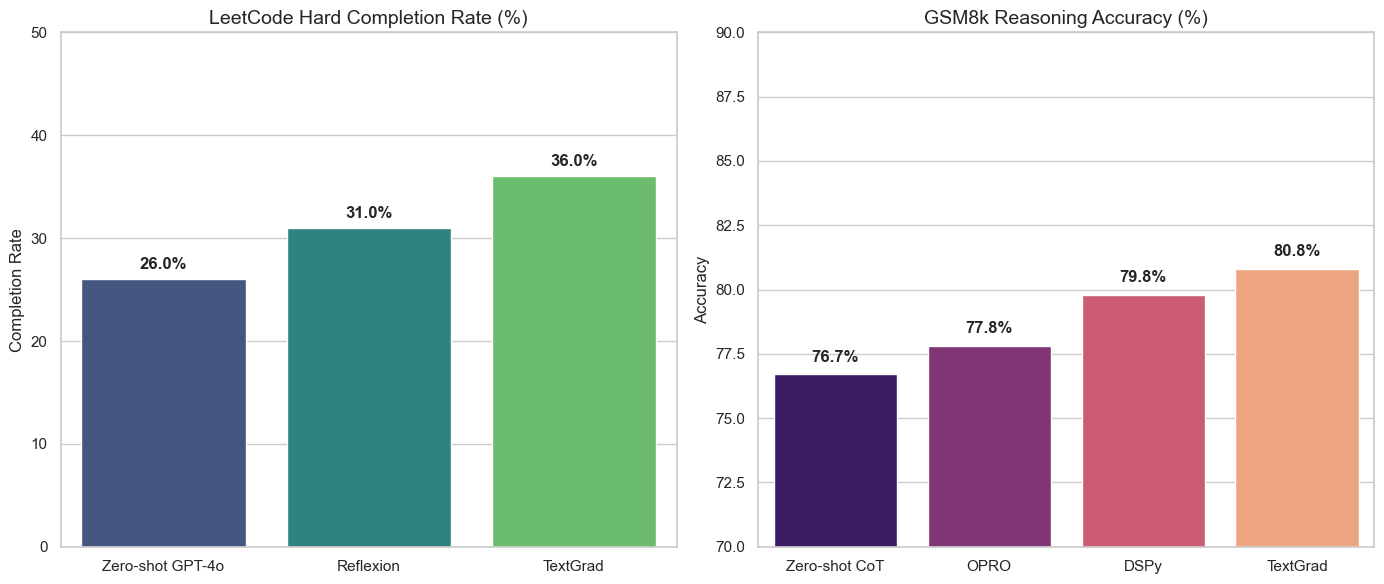

In [4]:
# Data extracted from Extended Data Fig. 3b and Extended Data Fig. 5a

# Coding Task (LeetCode Hard) Performance
methods_code = ['Zero-shot GPT-4o', 'Reflexion', 'TextGrad']
scores_code = [26.0, 31.0, 36.0] # Completion rates in %

# Reasoning Task (GSM8k) Performance
methods_math = ['Zero-shot CoT', 'OPRO', 'DSPy', 'TextGrad']
scores_math = [76.7, 77.8, 79.8, 80.8] # Accuracy in %

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: LeetCode Hard
sns.barplot(x=methods_code, y=scores_code, ax=axes[0], palette="viridis")
axes[0].set_title('LeetCode Hard Completion Rate (%)', fontsize=14)
axes[0].set_ylabel('Completion Rate')
axes[0].set_ylim(0, 50)
for i, v in enumerate(scores_code):
    axes[0].text(i, v + 1, f"{v}%", ha='center', fontweight='bold')

# Plot 2: GSM8k Accuracy
sns.barplot(x=methods_math, y=scores_math, ax=axes[1], palette="magma")
axes[1].set_title('GSM8k Reasoning Accuracy (%)', fontsize=14)
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(70, 90)
for i, v in enumerate(scores_math):
    axes[1].text(i, v + 0.5, f"{v}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('baseline_performance_eda.png')
plt.show()

### 3. Analysis of Failure Modes
According to the text, the "Loss Function" in TextGrad is an LLM that critiques the solution.
Common failure modes in the initial data that TextGrad aims to fix include:
1.  **Coding:** Edge cases in arrays (e.g., `nums[i] == k`).
2.  **Reasoning:** Incorrect interpretation of charts or values (e.g., reading 5 instead of 6).
3.  **Prompting:** Vague instructions that do not enforce step-by-step verification.

The EDA confirms that current baselines (Zero-shot) leave a significant margin for improvement (e.g., only 26% on LeetCode Hard), justifying the need for the TextGrad optimization loop.